# PIPELINE DE ANÁLISIS DE ARBITRAJE 

## Propósito

Este notebook implementa un pipeline completo para detectar y analizar oportunidades de arbitraje en mercados de renta variable europeos. El análisis se basa en datos de múltiples exchanges y simula el impacto de la latencia en la rentabilidad.

## Contenido

1. [FASE 1: Configuración e Importaciones](#fase-1)
2. [FASE 2: Descubrimiento de Datos](#fase-2)
3. [FASE 3: Carga y Filtrado de Datos](#fase-3)
4. [FASE 4: Construcción y Sincronización del Book Consolidado](#fase-4)
5. [FASE 5: Identificación y Validación de Señales](#fase-5)
6. [FASE 6: Modelado de Ejecución con Diferentes Escenarios de Velocidad](#fase-6)
7. [FASE 7: Análisis de Resultados](#fase-7)
   - 7A: Matrices de Rentabilidad y Métricas Agregadas
   - 7B: Visualización de Deterioro Temporal
   - 7C: Ranking y Análisis Detallado de Instrumentos
   - 7D: Síntesis de Resultados y Conclusiones Principales

## Arquitectura

```
┌─────────────────────────────────────────────────────────────────┐
│              ARBITRAJE_PIPELINE_EDUCATIVO.ipynb                │
│                    (Notebook Principal)                         │
└────────────────────────────┬────────────────────────────────────┘
                              │
                              │ Importa funciones desde módulos
                              │
        ┌─────────────────────┼─────────────────────┐
        │                     │                       │
        ▼                     ▼                       ▼
┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│ config_module│    │ data_loader_ │    │ data_cleaner_│
│              │    │ module       │    │ module       │
└──────────────┘    └──────────────┘    └──────────────┘
        │                     │                       │
        │                     ▼                       │
        │            ┌──────────────┐                 │
        │            │consolidator_ │                 │
        │            │module        │                 │
        │            └──────────────┘                 │
        │                     │                       │
        │                     ▼                       │
        │            ┌──────────────┐                 │
        │            │signal_genera │                 │
        │            │tor_module    │                 │
        │            └──────────────┘                 │
        │                     │                       │
        │                     ▼                       │
        │            ┌──────────────┐                 │
        │            │latency_simula │                 │
        │            │tor_module     │                 │
        │            └──────────────┘                 │
        │                     │                       │
        │                     ▼                       │
        │            ┌──────────────┐                 │
        └───────────►│analyzer_module│◄───────────────┘
                    └──────────────┘
```

## Referencias

- Módulos: `src/*.py`


# FASE 1: CONFIGURACIÓN E IMPORTACIONES {#fase-1}

## Objetivo

Configurar el entorno de trabajo, importar todas las librerías necesarias y cargar la configuración del sistema desde los módulos Python.

## ¿Qué hace esta fase?

Esta fase establece las bases del análisis:

1. **Configuración del Entorno**: Establece paths, encoding y configuración del sistema
2. **Importación de Librerías**: Carga pandas, numpy, matplotlib y otras dependencias
3. **Importación de Módulos**: Importa funciones desde los módulos modulares del sistema
4. **Carga de Configuración**: Obtiene parámetros críticos desde `config_module`

## Dependencias del Sistema

- **pandas**: Manipulación de DataFrames y análisis de datos
- **numpy**: Operaciones numéricas y arrays
- **matplotlib**: Visualización de gráficos
- **pathlib**: Manejo de rutas de archivos multiplataforma
- **Módulos personalizados**: Funciones específicas del pipeline de arbitraje

## Configuración Crítica

- **DATA_PATH**: Ruta al directorio de datos (DATA_SMALL o DATA_BIG)
- **DATE**: Fecha del análisis en formato YYYY-MM-DD
- **EXCHANGES**: Lista de exchanges a procesar (BME, AQUIS, CBOE, TURQUOISE)
- **MAGIC_NUMBERS**: Valores especiales que NO son precios reales
- **CONTINUOUS_TRADING_STATUS**: Códigos de estado válidos por exchange
- **LATENCY_LEVELS**: Niveles de latencia para simulación (0µs a 100ms)

## Flujo de Configuración

```
Inicio
  │
  ├─► Configurar encoding UTF-8 (Windows)
  │
  ├─► Agregar src/ al sys.path
  │
  ├─► Recargar módulos (evitar caché)
  │
  ├─► Importar config_module
  │
  ├─► Importar funciones de data_loader_module
  │
  ├─► Importar funciones de consolidator_module
  │
  ├─► Importar funciones de signal_generator_module
  │
  ├─► Importar funciones de latency_simulator_module
  │
  ├─► Importar funciones de analyzer_module
  │
  └─► Establecer variables de configuración
```

## Conceptos Clave

- **Magic Numbers**: Valores especiales (no reales) que indican estados del sistema como "unquoted", "market order", etc.
- **Continuous Trading**: Estado del mercado donde se pueden ejecutar operaciones normalmente
- **Latencia**: Tiempo de delay entre detectar una oportunidad y ejecutarla


In [1]:
# ============================================================================
# FASE 1: CONFIGURACIÓN E IMPORTACIONES
# ============================================================================

print("="*80)
print("FASE 1: CONFIGURACIÓN E IMPORTACIONES".center(80))
print("="*80)
print()

# Importar librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import sys
import importlib
import warnings
warnings.filterwarnings('ignore')

# Configurar encoding UTF-8 para Windows
if sys.platform == 'win32':
    try:
        sys.stdout.reconfigure(encoding='utf-8')
    except:
        pass

# Agregar directorio src al path para imports de módulos
PROJECT_ROOT = Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

print("Paso 1/4: Configurando entorno...")
print(f"   |-- Directorio del proyecto: {PROJECT_ROOT}")
print()

# Recargar módulos para evitar problemas de caché del kernel
print("Paso 2/4: Recargando módulos (evitar caché)...")
if 'data_loader_module' in sys.modules:
    importlib.reload(sys.modules['data_loader_module'])
    print("   |-- (INFO) Módulo data_loader_module recargado")
print()

# Importar configuración desde el módulo
print("Paso 3/4: Importando configuración...")
from config_module import config
print("   |-- (OK) Configuración importada desde config_module")
print()

# Importar todas las funciones desde los módulos
print("Paso 4/4: Importando funciones de módulos...")

# Funciones de carga de datos
from data_loader_module import (
    is_valid_price,
    load_qte_file,
    load_sts_file,
    filter_valid_prices,
    filter_continuous_trading,
    load_data_for_isin,
    find_all_isins
)
print("   |-- (OK) Funciones de data_loader_module importadas")

# Funciones de consolidated tape
from consolidator_module import (
    create_consolidated_tape,
    get_quote_at_epoch
)
print("   |-- (OK) Funciones de consolidator_module importadas")

# Funciones de detección de arbitraje
from signal_generator_module import (
    detect_arbitrage_opportunities,
    apply_rising_edge_detection
)
print("   |-- (OK) Funciones de signal_generator_module importadas")

# Función de simulación de latencia
from latency_simulator_module import simulate_latency_with_losses
print("   |-- (OK) Funciones de latency_simulator_module importadas")

# Funciones de análisis y reportes
from analyzer_module import (
    create_money_table,
    create_decay_chart,
    identify_top_opportunities,
    generate_summary_answers
)
print("   |-- (OK) Funciones de analyzer_module importadas")
print()

# ============================================================================
# VARIABLES DE CONFIGURACIÓN
# ============================================================================

print("="*80)
print("ESTABLECIENDO VARIABLES DE CONFIGURACIÓN".center(80))
print("="*80)
print()

# Ruta de datos - puede cambiarse aquí
# Para pruebas rápidas: usar config.DATA_SMALL_DIR
# Para análisis completo: usar config.DATA_BIG_DIR
DATA_PATH = str(config.DATA_SMALL_DIR)  # Cambiar a config.DATA_BIG_DIR para análisis completo
DATE = "2025-11-07"

# Usar configuración del módulo
EXCHANGES = config.EXCHANGES
CONTINUOUS_TRADING_STATUS = config.CONTINUOUS_TRADING_STATUS
MAGIC_NUMBERS = config.MAGIC_NUMBERS
LATENCY_LEVELS = config.LATENCY_LEVELS

print("CONFIGURACIÓN CARGADA")
print("-" * 80)
print(f"Ruta de datos:              {DATA_PATH}")
print(f"Fecha del análisis:         {DATE}")
print(f"Exchanges configurados:     {EXCHANGES}")
print(f"Magic numbers:              {len(MAGIC_NUMBERS)} valores")
print(f"Niveles de latencia:        {len(LATENCY_LEVELS)} niveles")
print(f"Latencias (primeras 5):     {[f'{lat/1000:.1f}ms' if lat > 0 else '0ms' for lat in LATENCY_LEVELS[:5]]} ... {LATENCY_LEVELS[-1]/1000:.0f}ms")
print("-" * 80)
print()

# Mostrar magic numbers
print("MAGIC NUMBERS CONFIGURADOS")
print("-" * 80)
for i, magic in enumerate(MAGIC_NUMBERS, 1):
    print(f"  {i}. {magic}")
print("-" * 80)
print()

# Mostrar estados de trading continuo por exchange
print("ESTADOS DE TRADING CONTINUO POR EXCHANGE")
print("-" * 80)
for exchange, statuses in CONTINUOUS_TRADING_STATUS.items():
    print(f"  {exchange:15} → {statuses}")
print("-" * 80)
print()

print("="*80)
print("(OK) FASE 1 COMPLETADA - CONFIGURACIÓN LISTA".center(80))
print("="*80)
print()


                     FASE 1: CONFIGURACIÓN E IMPORTACIONES                      

Paso 1/4: Configurando entorno...
   |-- Directorio del proyecto: c:\Users\Usuario\Downloads\TAREA_RENTA_VARIABLE

Paso 2/4: Recargando módulos (evitar caché)...

Paso 3/4: Importando configuración...
   |-- (OK) Configuración importada desde config_module

Paso 4/4: Importando funciones de módulos...
   |-- (OK) Funciones de data_loader_module importadas
   |-- (OK) Funciones de consolidator_module importadas
   |-- (OK) Funciones de signal_generator_module importadas
   |-- (OK) Funciones de latency_simulator_module importadas
   |-- (OK) Funciones de analyzer_module importadas

                    ESTABLECIENDO VARIABLES DE CONFIGURACIÓN                    

CONFIGURACIÓN CARGADA
--------------------------------------------------------------------------------
Ruta de datos:              c:\Users\Usuario\Downloads\TAREA_RENTA_VARIABLE\data\DATA_SMALL
Fecha del análisis:         2025-11-07
Exchanges conf

# FASE 2: DESCUBRIMIENTO DE DATOS {#fase-2}

## Objetivo

Identificar todos los instrumentos (ISINs) únicos disponibles en los datos para el análisis.

## ¿Qué hace esta fase?

Esta fase escanea el directorio de datos para encontrar todos los instrumentos disponibles:

1. **Búsqueda de Archivos**: Busca archivos QTE (quotes) en todos los exchanges
2. **Extracción de ISINs**: Extrae los códigos ISIN únicos de los nombres de archivo
3. **Validación**: Verifica que los ISINs encontrados sean válidos

## Estructura de Archivos

Los archivos siguen una convención de nombres específica:

```
QTE_YYYY-MM-DD_ISIN_TICKER_MIC_PART.csv.gz
STS_YYYY-MM-DD_ISIN_TICKER_MIC_PART.csv.gz
```

**Ejemplo:**
- `QTE_2025-11-07_ES0113900J37_SAN_XMAD_1.csv.gz`
- `STS_2025-11-07_ES0113900J37_SAN_XMAD_1.csv.gz`

**Componentes:**
- **QTE/STS**: Tipo de archivo (Quotes o Status)
- **YYYY-MM-DD**: Fecha en formato ISO
- **ISIN**: Código único del instrumento (International Securities Identification Number)
- **TICKER**: Símbolo del instrumento
- **MIC**: Market Identifier Code (XMAD, AQEU, CEUX, TQEX)
- **PART**: Número de parte (si el archivo está dividido)

## Flujo de Descubrimiento

```
Directorio de datos (DATA_PATH)
  │
  ├─► Exchange 1 (BME_YYYY-MM-DD/)
  │   ├─► Buscar archivos QTE_*.csv.gz
  │   └─► Extraer ISINs de nombres de archivo
  │
  ├─► Exchange 2 (AQUIS_YYYY-MM-DD/)
  │   ├─► Buscar archivos QTE_*.csv.gz
  │   └─► Extraer ISINs de nombres de archivo
  │
  ├─► Exchange 3 (CBOE_YYYY-MM-DD/)
  │   └─► ...
  │
  └─► Exchange 4 (TURQUOISE_YYYY-MM-DD/)
      └─► ...

  │
  └─► Consolidar ISINs únicos
```

## Conceptos Clave

- **ISIN**: International Securities Identification Number - Código único de 12 caracteres que identifica un instrumento financiero
- **Ticker**: Símbolo corto usado para identificar un instrumento en un exchange específico
- **MIC**: Market Identifier Code - Código de 4 caracteres que identifica un exchange (ej: XMAD = Bolsa de Madrid)


In [2]:
# ============================================================================
# FASE 2: DESCUBRIMIENTO DE DATOS
# ============================================================================

print("="*80)
print("FASE 2: DESCUBRIMIENTO DE DATOS".center(80))
print("="*80)
print()

print("Paso 1/2: Buscando archivos QTE en todos los exchanges...")
print(f"   |-- Directorio base: {DATA_PATH}")
print(f"   |-- Fecha: {DATE}")
print()

# Buscar todos los ISINs únicos
all_isins = find_all_isins(DATA_PATH, DATE)

print("Paso 2/2: Consolidando ISINs únicos...")
print(f"   |-- (OK) Encontrados {len(all_isins)} ISINs únicos")
print()

# Mostrar ISINs encontrados
if len(all_isins) > 0:
    print("ISINs ENCONTRADOS")
    print("-" * 80)
    if len(all_isins) <= 10:
        for i, isin in enumerate(all_isins, 1):
            print(f"  {i}. {isin}")
    else:
        for i, isin in enumerate(all_isins[:10], 1):
            print(f"  {i}. {isin}")
        print(f"  ... y {len(all_isins) - 10} más")
    print("-" * 80)
    print()
    
    # Crear tabla de resumen
    isin_summary = pd.DataFrame({
        'Total ISINs': [len(all_isins)],
        'Dataset': [Path(DATA_PATH).name],
        'Fecha': [DATE]
    })
    
    print("RESUMEN DE DESCUBRIMIENTO")
    print("-" * 80)
    print(isin_summary.to_string(index=False))
    print("-" * 80)
    print()
    
    # Mostrar ejemplo de nombres de archivo esperados
    print("EJEMPLO DE NOMBRES DE ARCHIVO ESPERADOS")
    print("-" * 80)
    example_isin = all_isins[0]
    for exchange in EXCHANGES:
        exchange_mic = {'BME': 'XMAD', 'AQUIS': 'AQEU', 'CBOE': 'CEUX', 'TURQUOISE': 'TQEX'}.get(exchange, exchange)
        print(f"  QTE: QTE_{DATE}_{example_isin}_TICKER_{exchange_mic}_1.csv.gz")
        print(f"  STS: STS_{DATE}_{example_isin}_TICKER_{exchange_mic}_1.csv.gz")
    print("-" * 80)
    print()
else:
    print("(WARNING) No se encontraron ISINs en los datos")
    print("   |-- Verificar que DATA_PATH y DATE sean correctos")
    print()

print("="*80)
print("(OK) FASE 2 COMPLETADA - ISINs DESCUBIERTOS".center(80))
print("="*80)
print()


                        FASE 2: DESCUBRIMIENTO DE DATOS                         

Paso 1/2: Buscando archivos QTE en todos los exchanges...
   |-- Directorio base: c:\Users\Usuario\Downloads\TAREA_RENTA_VARIABLE\data\DATA_SMALL
   |-- Fecha: 2025-11-07

Paso 2/2: Consolidando ISINs únicos...
   |-- (OK) Encontrados 1 ISINs únicos

ISINs ENCONTRADOS
--------------------------------------------------------------------------------
  1. ES0113900J37
--------------------------------------------------------------------------------

RESUMEN DE DESCUBRIMIENTO
--------------------------------------------------------------------------------
 Total ISINs    Dataset      Fecha
           1 DATA_SMALL 2025-11-07
--------------------------------------------------------------------------------

EJEMPLO DE NOMBRES DE ARCHIVO ESPERADOS
--------------------------------------------------------------------------------
  QTE: QTE_2025-11-07_ES0113900J37_TICKER_XMAD_1.csv.gz
  STS: STS_2025-11-07_ES0113900J

# FASE 3: CARGA Y FILTRADO DE DATOS {#fase-3}

## Objetivo

Cargar archivos QTE (quotes) y STS (status) para cada ISIN, eliminar datos inválidos y filtrar por estado de trading continuo.

## ¿Qué hace esta fase?

En esta fase se cargan los datos raw de cada exchange y se aplican 3 filtros críticos:

1. **Filtro de Magic Numbers**: Elimina precios especiales (666666.666, 999999.999, etc.) que NO son precios reales
2. **Filtro de Continuous Trading**: Solo considera períodos donde el mercado está activo y operativo
3. **Validación de Precios**: Verifica que bid < ask, cantidades > 0, precios > 0, etc.

## Formatos de Datos

### Archivo QTE (Quotes)

Contiene snapshots del order book en cada momento:

| Columna | Tipo | Descripción |
|---------|------|-------------|
| epoch | int64 | Timestamp en nanosegundos UTC |
| px_bid_0 | float64 | Precio del mejor bid (compra) |
| px_ask_0 | float64 | Precio del mejor ask (venta) |
| qty_bid_0 | float64 | Cantidad disponible en el bid |
| qty_ask_0 | float64 | Cantidad disponible en el ask |

### Archivo STS (Status)

Contiene cambios de estado del mercado:

| Columna | Tipo | Descripción |
|---------|------|-------------|
| epoch | int64 | Timestamp en nanosegundos UTC |
| market_trading_status | int64 | Código de estado del mercado |

## Flujo de Datos

```
Archivos CSV.gz (QTE + STS)
         ↓
   load_qte_file()
   load_sts_file()
         ↓
    DataFrames raw
         ↓
  filter_valid_prices()
  (Elimina magic numbers)
         ↓
filter_continuous_trading()
  (Merge_asof + filtro por estado)
         ↓
  DataFrames limpios
```

## Magic Numbers

Valores especiales que indican estados del sistema, NO son precios reales:

- **666666.666**: Unquoted/Unknown
- **999999.999**: Market Order
- **999999.989**: At Open Order
- **999999.988**: At Close Order
- **999999.979**: Pegged Order
- **999999.123**: Unquoted/Unknown

**CRÍTICO**: Estos valores deben eliminarse siempre antes del análisis.

## Estados de Trading Continuo

Cada exchange tiene códigos específicos que indican trading continuo:

- **BME**: [5832713, 5832756]
- **AQUIS**: [5308427]
- **CBOE**: [12255233]
- **TURQUOISE**: [7608181]

Solo se consideran válidos los snapshots donde el mercado está en uno de estos estados.

## Validación de Precios

Después de los filtros, se valida que:

- `px_bid_0 > 0` y `px_ask_0 > 0`
- `px_bid_0 < px_ask_0` (spread no cruzado)
- `qty_bid_0 > 0` y `qty_ask_0 > 0`
- Precios < 10000 EUR (sanity check)

## Conceptos Clave

- **Forward Fill**: No se aplica aquí, pero se usará en la consolidación para propagar el último precio conocido
- **Merge_asof**: Técnica de pandas para hacer join temporal, propagando el último estado conocido hacia adelante
- **Continuous Trading**: Estado del mercado donde se pueden ejecutar operaciones normalmente


In [3]:
# ============================================================================
# FASE 3: CARGA Y FILTRADO DE DATOS
# ============================================================================
# Esta fase procesa cada ISIN: carga datos y aplica filtros

# Almacenamiento para resultados finales
money_table_data = []

# Estadísticas globales para visualización
stats_summary = {
    'total_isins_processed': 0,
    'isins_with_data': 0,
    'isins_with_consolidated': 0,
    'isins_with_opportunities': 0,
    'isins_with_rising_edge': 0,
    'total_opportunities': 0,
    'total_rising_edge_opportunities': 0
}

# Diccionario para almacenar datos intermedios entre fases
phase_data = {}

print("="*80)
print("FASE 3: CARGA Y FILTRADO DE DATOS".center(80))
print("="*80)
print()

print("INICIANDO ANÁLISIS DE TODOS LOS ISINs")
print("-" * 80)
print(f"Total de ISINs a procesar:     {len(all_isins)}")
print(f"Niveles de latencia:            {len(LATENCY_LEVELS)}")
print(f"Exchanges configurados:         {len(EXCHANGES)}")
print("-" * 80)
print()

# Procesar cada ISIN
for isin_idx, isin in enumerate(all_isins, 1):
    print("\n" + "="*80)
    print(f"[{isin_idx}/{len(all_isins)}] PROCESANDO ISIN: {isin}".center(80))
    print("="*80)
    print()
    
    stats_summary['total_isins_processed'] += 1
    
    # ========================================================================
    # PASO 3.1: CARGA DE DATOS RAW
    # ========================================================================
    print("Paso 3.1/3.3: Cargando datos raw...")
    print(f"   |-- ISIN: {isin}")
    print(f"   |-- Fecha: {DATE}")
    print()
    
    data_dict = load_data_for_isin(DATA_PATH, DATE, isin)
    
    if not data_dict:
        print(f"   |-- (WARNING) No se encontraron datos para {isin}")
        print()
        continue
    
    stats_summary['isins_with_data'] += 1
    exchanges_found = list(data_dict.keys())
    print(f"   |-- (OK) Datos encontrados de {len(exchanges_found)} exchange(s): {exchanges_found}")
    print()
    
    # Mostrar estadísticas de carga por exchange
    load_stats = []
    for exchange, (qte_df, sts_df) in data_dict.items():
        load_stats.append({
            'Exchange': exchange,
            'Snapshots QTE': len(qte_df),
            'Snapshots STS': len(sts_df),
            'Epoch Min': f"{qte_df['epoch'].min():,}" if not qte_df.empty else "N/A",
            'Epoch Max': f"{qte_df['epoch'].max():,}" if not qte_df.empty else "N/A"
        })
    
    if load_stats:
        load_df = pd.DataFrame(load_stats)
        print("ESTADÍSTICAS DE CARGA POR EXCHANGE")
        print("-" * 80)
        print(load_df.to_string(index=False))
        print("-" * 80)
        print()
    
    # ========================================================================
    # PASO 3.2: FILTRADO Y LIMPIEZA
    # ========================================================================
    print("Paso 3.2/3.3: Aplicando filtros de limpieza...")
    print()
    
    # El filtrado ya se aplica dentro de load_data_for_isin, pero mostramos estadísticas
    filtered_stats = []
    total_after = 0
    
    for exchange, (qte_df, sts_df) in data_dict.items():
        # Contar snapshots después del filtrado (ya filtrados en load_data_for_isin)
        after_count = len(qte_df)
        total_after += after_count
        
        filtered_stats.append({
            'Exchange': exchange,
            'Snapshots Válidos': after_count,
            'Estado': '(OK) Datos filtrados' if after_count > 0 else '(WARNING) Sin datos válidos'
        })
    
    if filtered_stats:
        filtered_df = pd.DataFrame(filtered_stats)
        print("ESTADÍSTICAS DE FILTRADO POR EXCHANGE")
        print("-" * 80)
        print(filtered_df.to_string(index=False))
        print("-" * 80)
        print()
        print(f"Total snapshots válidos después de filtrado: {total_after:,}")
        print()
        print("FILTROS APLICADOS:")
        print("  1. Magic numbers eliminados")
        print("  2. Solo continuous trading")
        print("  3. Precios válidos (bid > 0, ask > 0, bid < ask)")
        print()
    
    # ========================================================================
    # PASO 3.3: PREPARACIÓN PARA CONSOLIDACIÓN
    # ========================================================================
    print("Paso 3.3/3.3: Datos listos para consolidación...")
    print(f"   |-- (OK) {len(data_dict)} exchanges con datos válidos")
    print()
    
    # Guardar datos para la siguiente fase
    phase_data[isin] = {
        'data_dict': data_dict,
        'isin_idx': isin_idx
    }
    
    print("="*80)
    print("(OK) FASE 3 COMPLETADA - DATOS CARGADOS Y FILTRADOS".center(80))
    print("="*80)
    print()


                       FASE 3: CARGA Y FILTRADO DE DATOS                        

INICIANDO ANÁLISIS DE TODOS LOS ISINs
--------------------------------------------------------------------------------
Total de ISINs a procesar:     1
Niveles de latencia:            14
Exchanges configurados:         4
--------------------------------------------------------------------------------


                      [1/1] PROCESANDO ISIN: ES0113900J37                       

Paso 3.1/3.3: Cargando datos raw...
   |-- ISIN: ES0113900J37
   |-- Fecha: 2025-11-07

   |-- (OK) Datos encontrados de 4 exchange(s): ['BME', 'AQUIS', 'CBOE', 'TURQUOISE']

ESTADÍSTICAS DE CARGA POR EXCHANGE
--------------------------------------------------------------------------------
 Exchange  Snapshots QTE  Snapshots STS             Epoch Min             Epoch Max
      BME         362896              7 1,762,502,419,350,780 1,762,533,000,577,049
    AQUIS         101559              6 1,762,502,416,697,531 1,762,532,9

# FASE 4: CONSTRUCCIÓN Y SINCRONIZACIÓN DEL BOOK CONSOLIDADO {#fase-4}

## Objetivo

Crear un único DataFrame consolidado que sincronice temporalmente los datos de todos los exchanges, permitiendo comparar precios entre venues en cada momento.

## ¿Qué hace esta fase?

Esta fase transforma múltiples DataFrames (uno por exchange) en un único DataFrame sincronizado:

1. **Renombrado de Columnas**: Prefija cada columna con el nombre del exchange
2. **Merge Temporal**: Combina todos los exchanges usando `epoch` como clave
3. **Forward Fill**: Propaga el último precio conocido hasta el próximo update
4. **Sincronización**: Crea un timeline único con todos los timestamps de todos los exchanges

## Estructura del Book Consolidado

El resultado es un DataFrame donde:

- **Índice**: `epoch` (timestamp en nanosegundos)
- **Columnas**: Prefijadas por exchange
  - `{EXCHANGE}_bid`: Precio del mejor bid
  - `{EXCHANGE}_ask`: Precio del mejor ask
  - `{EXCHANGE}_bidqty`: Cantidad en el bid
  - `{EXCHANGE}_askqty`: Cantidad en el ask

**Ejemplo de estructura:**
```
| epoch              | BME_bid | BME_ask | AQUIS_bid | AQUIS_ask | ... |
|--------------------|---------|---------|-----------|-----------|-----|
| 1762502416697156   | 8.815   | 8.820   | 8.814     | 8.819     | ... |
| 1762502416697157   | 8.815   | 8.820   | 8.814     | 8.819     | ... |
```

## ¿Por qué Forward Fill?

En mercados fragmentados, cada exchange actualiza a diferentes frecuencias:

- **XMAD** puede actualizar cada 100ms
- **AQEU** puede actualizar cada 200ms
- **CEUX** puede actualizar cada 150ms

Sin forward fill, tendríamos NaNs en cada timestamp donde un exchange no actualiza, lo cual haría **imposible comparar precios** entre exchanges.

Con forward fill, asumimos que el último precio conocido sigue vigente hasta el próximo update, que es estándar en análisis de order books.

## Flujo de Consolidación

```
DataFrames por Exchange
  │
  ├─► BME DataFrame
  │   ├─► Renombrar: bid → BME_bid, ask → BME_ask, etc.
  │   └─► Seleccionar: epoch, BME_bid, BME_ask, BME_bidqty, BME_askqty
  │
  ├─► AQUIS DataFrame
  │   ├─► Renombrar: bid → AQUIS_bid, ask → AQUIS_ask, etc.
  │   └─► Seleccionar: epoch, AQUIS_bid, AQUIS_ask, AQUIS_bidqty, AQUIS_askqty
  │
  └─► ... (otros exchanges)
      │
      └─► Merge iterativo con outer join en 'epoch'
          │
          └─► DataFrame con todos los timestamps únicos
              │
              └─► Ordenar por epoch
                  │
                  └─► Forward fill (ffill)
                      │
                      └─► Book Consolidado Final
```

## Análisis de Spreads Cross-Venue

Una vez consolidado, podemos analizar:

- **Spread mínimo cross-venue**: Diferencia entre el mejor ask y el mejor bid globales
- **Oportunidades de arbitraje**: Cuando el mejor bid global > mejor ask global
- **Sincronización temporal**: Verificar que los timestamps estén alineados

## Conceptos Clave

- **Outer Join**: Mantiene todos los timestamps de todos los exchanges
- **Forward Fill (ffill)**: Propaga el último valor conocido hacia adelante
- **Sincronización Temporal**: Alinear datos de diferentes frecuencias de actualización

In [ ]:
# ============================================================================
# FASE 4: CONSTRUCCIÓN Y SINCRONIZACIÓN DEL BOOK CONSOLIDADO
# ============================================================================

print("="*80)
print("FASE 4: CONSTRUCCIÓN Y SINCRONIZACIÓN DEL BOOK CONSOLIDADO".center(80))
print("="*80)
print()

# Procesar cada ISIN que pasó la FASE 3
for isin, isin_data in phase_data.items():
    isin_idx = isin_data['isin_idx']
    data_dict = isin_data['data_dict']
    
    print("\n" + "="*80)
    print(f"[{isin_idx}/{len(all_isins)}] FASE 4 - ISIN: {isin}".center(80))
    print("="*80)
    print()
    
    print("Paso 4.1/4.3: Creando book consolidado...")
    print("   |-- Renombrando columnas por exchange")
    print("   |-- Haciendo merge temporal (outer join en epoch)")
    print()
    
    consolidated = create_consolidated_tape(data_dict)
    
    if consolidated.empty:
        print(f"   |-- (WARNING) No se pudo crear consolidated tape para {isin}")
        print()
        # Actualizar phase_data para indicar que no hay consolidated
        phase_data[isin]['consolidated'] = None
        continue
    
    stats_summary['isins_with_consolidated'] += 1
    print(f"   |-- (OK) Consolidated tape creado exitosamente")
    print()
    
    print("Paso 4.2/4.3: Estadísticas del book consolidado...")
    print()
    
    print("ESTADÍSTICAS DEL BOOK CONSOLIDADO")
    print("-" * 80)
    print(f"Total snapshots:              {len(consolidated):,}")
    print(f"Columnas totales:             {len(consolidated.columns)}")
    print("-" * 80)
    print()
    
    # Mostrar columnas disponibles
    bid_cols = [col for col in consolidated.columns if '_bid' in col and '_bidqty' not in col]
    ask_cols = [col for col in consolidated.columns if '_ask' in col and '_askqty' not in col]
    print(f"Exchanges en book:           {len(bid_cols)}")
    print(f"Columnas bid:                {bid_cols}")
    print(f"Columnas ask:                {ask_cols}")
    print()
    
    print("Paso 4.3/4.3: Muestra del book consolidado...")
    print()
    
    # Mostrar muestra del book consolidado
    print("MUESTRA DEL BOOK CONSOLIDADO (primeras 5 filas)")
    print("-" * 80)
    display_cols = ['epoch'] if 'epoch' in consolidated.columns else []
    display_cols += bid_cols[:4] + ask_cols[:4]  # Mostrar primeros 4 exchanges
    available_display_cols = [col for col in display_cols if col in consolidated.columns]
    if available_display_cols:
        print(consolidated[available_display_cols].head().to_string())
    else:
        # Si epoch es el índice, mostrar directamente
        print(consolidated.head()[bid_cols[:4] + ask_cols[:4]].to_string())
    print("-" * 80)
    print()
    
    # Análisis de spreads cross-venue
    print("ANÁLISIS DE SPREADS CROSS-VENUE")
    print("-" * 80)
    if len(bid_cols) > 0 and len(ask_cols) > 0:
        # Calcular mejor bid y mejor ask globales
        all_bids = consolidated[bid_cols]
        all_asks = consolidated[ask_cols]
        global_max_bid = all_bids.max(axis=1)
        global_min_ask = all_asks.min(axis=1)
        spread = global_min_ask - global_max_bid
        
        print(f"Mejor bid global (promedio):  €{global_max_bid.mean():.4f}")
        print(f"Mejor ask global (promedio):  €{global_min_ask.mean():.4f}")
        print(f"Spread promedio:              €{spread.mean():.4f}")
        print(f"Spread mínimo:                €{spread.min():.4f}")
        print(f"Spread máximo:                €{spread.max():.4f}")
        if spread.min() < 0:
            print(f"(INFO) Spread negativo detectado: {spread.min():.4f} → Oportunidad de arbitraje")
    print("-" * 80)
    print()
    
    # Guardar consolidated para la siguiente fase
    phase_data[isin]['consolidated'] = consolidated
    
    print("="*80)
    print("(OK) FASE 4 COMPLETADA - BOOK CONSOLIDADO CREADO".center(80))
    print("="*80)
    print()


           FASE 4: CONSTRUCCIÓN Y SINCRONIZACIÓN DEL BOOK CONSOLIDADO           


                       [1/1] FASE 4 - ISIN: ES0113900J37                        

Paso 4.1/4.3: Creando book consolidado...
   |-- Renombrando columnas por exchange
   |-- Haciendo merge temporal (outer join en epoch)

   |-- (OK) Consolidated tape creado exitosamente

Paso 4.2/4.3: Estadísticas del book consolidado...

ESTADÍSTICAS DEL BOOK CONSOLIDADO
--------------------------------------------------------------------------------
Total snapshots:              585,252
Columnas totales:             17
Rango temporal (min):        1,762,502,416,697,156 µs
Rango temporal (max):        1,762,533,001,057,722 µs
Duración total:               0.51 minutos
--------------------------------------------------------------------------------

Exchanges en book:           4
Columnas bid:                ['BME_bid', 'AQUIS_bid', 'CBOE_bid', 'TURQUOISE_bid']
Columnas ask:                ['BME_ask', 'AQUIS_ask', 'CBOE_as

# FASE 5: IDENTIFICACIÓN Y VALIDACIÓN DE SEÑALES {#fase-5}

## Objetivo

Identificar oportunidades de arbitraje en el book consolidado y validar que sean únicas y ejecutables, eliminando duplicados causados por la propagación temporal de precios.

## ¿Qué hace esta fase?

Esta fase detecta y valida oportunidades de arbitraje en dos pasos:

1. **Identificación Básica**: Detecta todos los momentos donde `global_max_bid > global_min_ask`
2. **Validación (Rising Edge Detection)**: Filtra para mantener solo las oportunidades únicas, eliminando duplicados causados por forward fill

## Identificación de Oportunidades

Una oportunidad de arbitraje existe cuando:

```
global_max_bid > global_min_ask
```

Donde:
- **global_max_bid**: El mejor precio de compra disponible en cualquier exchange
- **global_min_ask**: El mejor precio de venta disponible en cualquier exchange

Si el mejor bid es mayor que el mejor ask, podemos:
- **Comprar** en el exchange con el mejor ask (más barato)
- **Vender** en el exchange con el mejor bid (más caro)
- **Profit**: Diferencia entre los precios

## Rising Edge Detection

El forward fill en la FASE 4 propaga precios hacia adelante, lo que causa que la misma oportunidad aparezca múltiples veces en timestamps consecutivos.

**Rising Edge Detection v4** resuelve esto rastreando:

- **Consumo de Liquidez Independiente**: Trackea compra (bid) y venta (ask) por separado
- **Reset por Cambio**: Si el precio o exchange del bid cambia → resetea consumo del bid
- **Reset por Cambio**: Si el precio o exchange del ask cambia → resetea consumo del ask
- **Mantiene Estado**: Si un lado no cambia, mantiene su consumo acumulado

Esto asegura que solo contamos cada oportunidad una vez, cuando aparece por primera vez.

## Flujo de Validación

```
Oportunidades Detectadas
         ↓
  detect_arbitrage_opportunities()
  (Calcula profit_per_share, tradeable_qty, total_profit)
         ↓
  apply_rising_edge_detection()
  (Filtra duplicados, mantiene solo rising edges)
         ↓
  Oportunidades Validadas (Únicas)
```

## Conceptos Clave

- **Global Max Bid**: Mejor precio de compra disponible en todos los exchanges
- **Global Min Ask**: Mejor precio de venta disponible en todos los exchanges
- **Rising Edge**: Primera aparición de una oportunidad (antes de que se propague)
- **Liquidez Consumida**: Cantidad de acciones ya "usadas" en una oportunidad previa


In [6]:
# ============================================================================
# FASE 5: IDENTIFICACIÓN Y VALIDACIÓN DE SEÑALES
# ============================================================================

print("="*80)
print("FASE 5: IDENTIFICACIÓN Y VALIDACIÓN DE SEÑALES".center(80))
print("="*80)
print()

# Procesar cada ISIN que pasó la FASE 4
for isin, isin_data in phase_data.items():
    if 'consolidated' not in isin_data or isin_data['consolidated'] is None:
        continue
    
    isin_idx = isin_data['isin_idx']
    consolidated = isin_data['consolidated']
    
    print("\n" + "="*80)
    print(f"[{isin_idx}/{len(all_isins)}] FASE 5 - ISIN: {isin}".center(80))
    print("="*80)
    print()
    
    # Paso 1: Identificación básica
    print("Paso 5.1/5.2: Identificando todas las señales...")
    print("   |-- Calculando global_max_bid y global_min_ask")
    print("   |-- Aplicando condición: global_max_bid > global_min_ask")
    print()
    
    opportunities = detect_arbitrage_opportunities(consolidated)
    
    if opportunities.empty:
        print(f"   |-- (WARNING) No se encontraron oportunidades de arbitraje para {isin}")
        print()
        phase_data[isin]['opportunities'] = None
        phase_data[isin]['opps_final'] = None
        continue
    
    stats_summary['isins_with_opportunities'] += 1
    stats_summary['total_opportunities'] += len(opportunities)
    print(f"   |-- (OK) Señales identificadas: {len(opportunities):,}")
    print()
    
    # Mostrar estadísticas de oportunidades
    if len(opportunities) > 0:
        print("ESTADÍSTICAS DE SEÑALES (ANTES DE VALIDACIÓN)")
        print("-" * 80)
        opp_stats = {
            'Total señales': len(opportunities),
            'Rentabilidad total teórica': f"€{opportunities['total_profit'].sum():,.2f}",
            'Rentabilidad promedio': f"€{opportunities['profit_per_share'].mean():.4f} EUR/share",
            'Rentabilidad máxima': f"€{opportunities['total_profit'].max():.2f}",
            'Cantidad promedio ejecutable': f"{opportunities['tradeable_qty'].mean():.0f} shares"
        }
        for key, value in opp_stats.items():
            print(f"{key:35} {value}")
        print("-" * 80)
        print()
        
        # Muestra de señales
        print("MUESTRA DE SEÑALES (primeras 5)")
        print("-" * 80)
        sample_cols = ['epoch', 'buy_exchange', 'sell_exchange', 'profit_per_share', 'tradeable_qty', 'total_profit']
        available_sample_cols = [col for col in sample_cols if col in opportunities.columns]
        if available_sample_cols:
            print(opportunities[available_sample_cols].head().to_string(index=False))
        print("-" * 80)
        print()
    
    # Paso 2: Validación (Rising edge detection)
    print("Paso 5.2/5.2: Aplicando filtro de validación de unicidad...")
    print("   |-- Rising Edge Detection v4 (Independent Side Tracking)")
    print("   |-- Trackeando liquidez consumida por exchange y lado")
    print()
    
    opportunities_filtered = apply_rising_edge_detection(opportunities)
    
    if opportunities_filtered.empty:
        print(f"   |-- (WARNING) No quedaron oportunidades después del filtro de liquidez para {isin}")
        print()
        phase_data[isin]['opportunities'] = opportunities
        phase_data[isin]['opps_final'] = None
        continue
    
    stats_summary['isins_with_rising_edge'] += 1
    
    # Filtrar solo las que pasaron el rising edge
    if 'is_rising_edge' in opportunities_filtered.columns:
        opps_final = opportunities_filtered[opportunities_filtered['is_rising_edge']].copy()
    else:
        # Si no existe la columna, usar todas las oportunidades
        opps_final = opportunities_filtered.copy()
    stats_summary['total_rising_edge_opportunities'] += len(opps_final)
    
    reduction_pct = ((len(opportunities) - len(opps_final)) / len(opportunities) * 100) if len(opportunities) > 0 else 0
    print(f"   |-- (OK) Señales validadas (únicas): {len(opps_final):,}")
    print(f"   |-- (INFO) Señales descartadas: {len(opportunities) - len(opps_final):,} ({reduction_pct:.1f}%)")
    print()
    
    # Estadísticas después de validación
    if len(opps_final) > 0:
        print("ESTADÍSTICAS DE SEÑALES (DESPUÉS DE VALIDACIÓN)")
        print("-" * 80)
        filtered_stats = {
            'Señales validadas': len(opps_final),
            'Rentabilidad total teórica': f"€{opps_final['total_profit'].sum():,.2f}",
            'Rentabilidad promedio': f"€{opps_final['profit_per_share'].mean():.4f} EUR/share",
            'Rentabilidad máxima': f"€{opps_final['total_profit'].max():.2f}",
            'Cantidad promedio ejecutable': f"{opps_final['tradeable_qty'].mean():.0f} shares"
        }
        for key, value in filtered_stats.items():
            print(f"{key:35} {value}")
        print("-" * 80)
        print()
        
        # Muestra de señales validadas
        print("MUESTRA DE SEÑALES VALIDADAS (top 5 por rentabilidad)")
        print("-" * 80)
        sample = opps_final.nlargest(5, 'total_profit')[['epoch', 'buy_exchange', 'sell_exchange', 
                                                           'buy_price', 'sell_price', 'profit_per_share', 
                                                           'tradeable_qty', 'total_profit']]
        print(sample.to_string(index=False))
        print("-" * 80)
        print()
    
    # Guardar oportunidades para la siguiente fase
    phase_data[isin]['opportunities'] = opportunities
    phase_data[isin]['opps_final'] = opps_final
    
    print("="*80)
    print("(OK) FASE 5 COMPLETADA - SEÑALES IDENTIFICADAS Y VALIDADAS".center(80))
    print("="*80)
    print()


                 FASE 5: IDENTIFICACIÓN Y VALIDACIÓN DE SEÑALES                 


                       [1/1] FASE 5 - ISIN: ES0113900J37                        

Paso 5.1/5.2: Identificando todas las señales...
   |-- Calculando global_max_bid y global_min_ask
   |-- Aplicando condición: global_max_bid > global_min_ask

   |-- (OK) Señales identificadas: 4,054

ESTADÍSTICAS DE SEÑALES (ANTES DE VALIDACIÓN)
--------------------------------------------------------------------------------
Total señales                       4054
Rentabilidad total teórica          €4,212.03
Rentabilidad promedio               €0.0013 EUR/share
Rentabilidad máxima                 €15.51
Cantidad promedio ejecutable        755 shares
--------------------------------------------------------------------------------

MUESTRA DE SEÑALES (primeras 5)
--------------------------------------------------------------------------------
           epoch buy_exchange sell_exchange  profit_per_share  tradeable_qty  to

# FASE 6: MODELADO DE EJECUCIÓN CON DIFERENTES ESCENARIOS DE VELOCIDAD {#fase-6}

## Objetivo

Simular el impacto de diferentes niveles de latencia en la rentabilidad de las oportunidades detectadas, modelando cómo el delay operacional afecta la ejecución real.

## ¿Qué hace esta fase?

Esta fase simula la ejecución de cada oportunidad considerando diferentes escenarios de velocidad:

1. **Simulación de Latencia**: Para cada nivel de latencia, calcula el profit/loss realizable
2. **Time Machine**: Obtiene los precios disponibles en T + Latency
3. **Validación de Oportunidad**: Verifica si la oportunidad sigue existiendo después del delay
4. **Cálculo de Profit/Loss**: Calcula el resultado real considerando el slippage temporal

## Conceptos Clave

- **Time Machine**: Técnica para obtener precios históricos en un momento específico
- **Slippage**: Diferencia entre el precio esperado y el precio real de ejecución
- **Vida Media**: Tiempo en que el profit se reduce al 50% del máximo


      FASE 6: MODELADO DE EJECUCIÓN CON DIFERENTES ESCENARIOS DE VELOCIDAD      


                       [1/1] FASE 6 - ISIN: ES0113900J37                        

Simulando ejecución para diferentes escenarios de velocidad...
   |-- Total niveles de latencia: 14
   |-- Rango: 0µs (0.0ms) a 100ms (100ms)

   Procesando latencia 1/14: 0µs (0.0ms)...
   Procesando latencia 5/14: 2000µs (2.0ms)...
   Procesando latencia 10/14: 15000µs (15.0ms)...
   Procesando latencia 14/14: 100000µs (100.0ms)...

RESULTADOS POR ESCENARIO DE VELOCIDAD
--------------------------------------------------------------------------------
Latencia (µs)   Latencia (ms)   Profit/Loss (€)      % de 0 latencia Estado    
--------------------------------------------------------------------------------
0               0.000           €215.49              100.0%          (OK)
100             0.100           €219.16              101.7%          (OK)
500             0.500           €178.22              82.7%           (

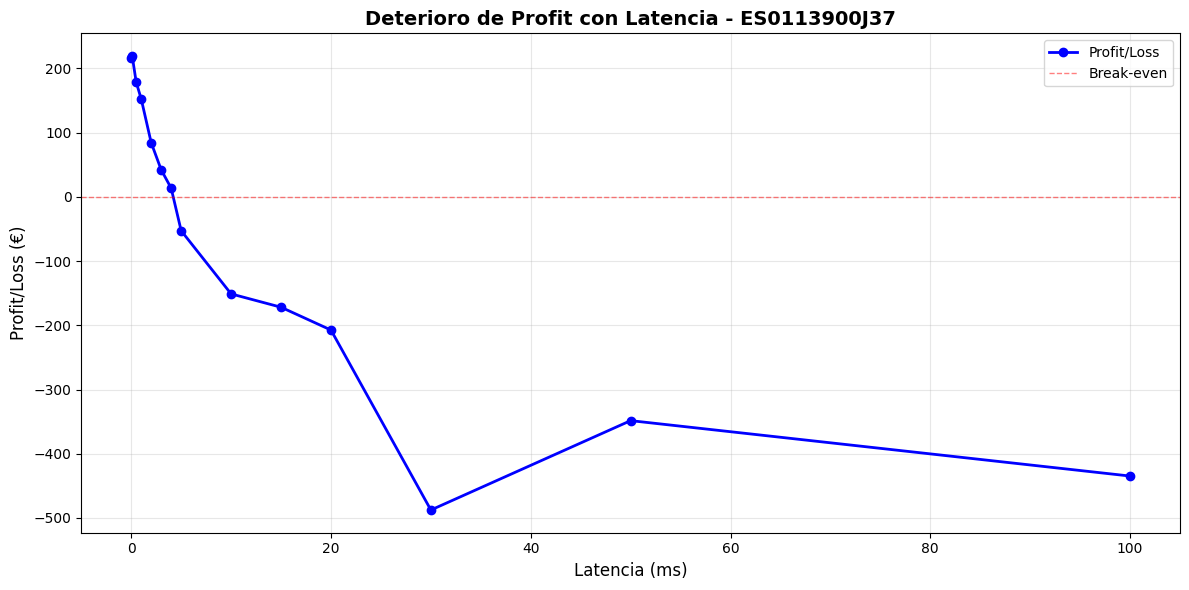


(OK) ISIN ES0113900J37 procesado exitosamente

────────────────────────────────────────────────────────────────────────────────


                              ANÁLISIS COMPLETADO                               

RESUMEN DEL ANÁLISIS
--------------------------------------------------------------------------------
 Total ISINs Procesados  ISINs con Datos  ISINs con Consolidated Tape  ISINs con Oportunidades  ISINs con Rising Edge  Total Oportunidades  Oportunidades Válidas
                      1                1                            1                        1                      1                 4054                    348
--------------------------------------------------------------------------------




In [7]:
# ============================================================================
# FASE 6: MODELADO DE EJECUCIÓN CON DIFERENTES ESCENARIOS DE VELOCIDAD
# ============================================================================

print("="*80)
print("FASE 6: MODELADO DE EJECUCIÓN CON DIFERENTES ESCENARIOS DE VELOCIDAD".center(80))
print("="*80)
print()

# Procesar cada ISIN que pasó la FASE 5
for isin, isin_data in phase_data.items():
    if 'opps_final' not in isin_data or isin_data['opps_final'] is None:
        continue
    
    if 'consolidated' not in isin_data or isin_data['consolidated'] is None:
        continue
    
    isin_idx = isin_data['isin_idx']
    opps_final = isin_data['opps_final']
    consolidated = isin_data['consolidated']
    
    print("\n" + "="*80)
    print(f"[{isin_idx}/{len(all_isins)}] FASE 6 - ISIN: {isin}".center(80))
    print("="*80)
    print()
    
    print("Simulando ejecución para diferentes escenarios de velocidad...")
    print(f"   |-- Total niveles de latencia: {len(LATENCY_LEVELS)}")
    print(f"   |-- Rango: 0µs ({LATENCY_LEVELS[0]/1000:.1f}ms) a {LATENCY_LEVELS[-1]/1000:.0f}ms ({LATENCY_LEVELS[-1]/1000:.0f}ms)")
    print()
    
    profits_by_latency = {}
    
    for latency_idx, latency_us in enumerate(LATENCY_LEVELS, 1):
        if latency_idx % 5 == 0 or latency_idx == 1 or latency_idx == len(LATENCY_LEVELS):
            latency_ms = latency_us / 1000
            print(f"   Procesando latencia {latency_idx}/{len(LATENCY_LEVELS)}: {latency_us}µs ({latency_ms:.1f}ms)...")
        
        profit = simulate_latency_with_losses(opps_final, consolidated, latency_us)
        profits_by_latency[latency_us] = profit
        
        money_table_data.append({
            'ISIN': isin,
            'Latency_us': latency_us,
            'Profit_EUR': profit
        })
    
    print()
    print("RESULTADOS POR ESCENARIO DE VELOCIDAD")
    print("-" * 80)
    print(f"{'Latencia (µs)':<15} {'Latencia (ms)':<15} {'Profit/Loss (€)':<20} {'% de 0 latencia':<15} {'Estado':<10}")
    print("-" * 80)
    
    zero_latency_profit = profits_by_latency[0]
    latency_results = []
    
    for latency_us in LATENCY_LEVELS:
        profit = profits_by_latency[latency_us]
        latency_ms = latency_us / 1000
        if zero_latency_profit != 0:
            pct = (profit / zero_latency_profit * 100) if zero_latency_profit != 0 else 0
            pct_str = f"{pct:.1f}%"
        else:
            pct_str = "N/A"
        
        # Estado: positivo = ganancia, negativo = pérdida, cero = neutral
        profit_str = f"€{profit:,.2f}"
        if profit > 0:
            status = "(OK)"
        elif profit < 0:
            status = "(LOSS)"
        else:
            status = "(NEUTRAL)"
        
        print(f"{latency_us:<15} {latency_ms:<15.3f} {profit_str:<20} {pct_str:<15} {status}")
        
        latency_results.append({
            'Latencia (ms)': latency_ms,
            'Profit/Loss (€)': profit,
            '% de 0 latencia': pct if zero_latency_profit != 0 else 0
        })
    
    print("-" * 80)
    print(f"Profit total a latencia 0: €{zero_latency_profit:,.2f}")
    print()
    
    # Análisis de deterioro
    print("ANÁLISIS DE DETERIORO")
    print("-" * 80)
    if zero_latency_profit > 0:
        # Calcular vida media (50% del profit restante)
        half_profit = zero_latency_profit / 2
        half_life_ms = None
        
        for lat_us in LATENCY_LEVELS:
            profit = profits_by_latency[lat_us]
            if profit <= half_profit:
                half_life_ms = lat_us / 1000
                break
        
        if half_life_ms is None:
            half_life_ms = LATENCY_LEVELS[-1] / 1000
        
        print(f"Vida media (50% profit restante): ~{half_life_ms:.1f}ms")
        
        # Puntos clave
        key_latencies = [1000, 10000, 100000]  # 1ms, 10ms, 100ms
        for lat_us in key_latencies:
            if lat_us in profits_by_latency:
                profit_at_latency = profits_by_latency[lat_us]
                pct_at_latency = (profit_at_latency / zero_latency_profit * 100) if zero_latency_profit != 0 else 0
                print(f"Profit a {lat_us/1000:.0f}ms: €{profit_at_latency:,.2f} ({pct_at_latency:.1f}%)")
    print("-" * 80)
    print()
    
    # Crear gráfico simple de decay para este ISIN
    if zero_latency_profit > 0:
        latency_df = pd.DataFrame(latency_results)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(latency_df['Latencia (ms)'], latency_df['Profit/Loss (€)'], 'b-o', linewidth=2, markersize=6, label='Profit/Loss')
        ax.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Break-even')
        ax.set_xlabel('Latencia (ms)', fontsize=12)
        ax.set_ylabel('Profit/Loss (€)', fontsize=12)
        ax.set_title(f'Deterioro de Profit con Latencia - {isin}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.tight_layout()
        plt.show()
        print()
    
    print(f"(OK) ISIN {isin} procesado exitosamente")
    print()
    print("─"*80)
    print()

# ========================================================================
# RESUMEN FINAL DEL ANÁLISIS
# ========================================================================
print("\n" + "="*80)
print("ANÁLISIS COMPLETADO".center(80))
print("="*80)
print()

summary_df = pd.DataFrame([{
    'Total ISINs Procesados': stats_summary['total_isins_processed'],
    'ISINs con Datos': stats_summary['isins_with_data'],
    'ISINs con Consolidated Tape': stats_summary['isins_with_consolidated'],
    'ISINs con Oportunidades': stats_summary['isins_with_opportunities'],
    'ISINs con Rising Edge': stats_summary['isins_with_rising_edge'],
    'Total Oportunidades': stats_summary['total_opportunities'],
    'Oportunidades Válidas': stats_summary['total_rising_edge_opportunities']
}])

print("RESUMEN DEL ANÁLISIS")
print("-" * 80)
print(summary_df.to_string(index=False))
print("-" * 80)
print()
print("="*80)
print()


## Resumen del Loop Principal

El loop principal (Cell 6) procesa cada ISIN ejecutando las fases 3, 4, 5 y 6 en secuencia. Al finalizar el loop, se genera un resumen con las estadísticas globales del análisis.

# FASE 7A: MATRICES DE RENTABILIDAD Y MÉTRICAS AGREGADAS {#fase-7a}

## Objetivo

Construir matrices resultado-instrumento que muestren la rentabilidad total por ISIN y nivel de latencia, permitiendo análisis comparativo y agregación de métricas.

## ¿Qué hace esta fase?

Esta fase genera dos tipos de tablas:

1. **Money Table (Tabla Pivot)**: Matriz ISIN × Latencia con profit total
2. **Summary by Latency**: Resumen agregado por nivel de latencia

## Construcción de Matrices Resultado-Instrumento

La Money Table es una tabla pivot donde:

- **Filas**: ISINs (instrumentos)
- **Columnas**: Niveles de latencia (0µs, 100µs, 500µs, ..., 100ms)
- **Valores**: Profit total realizado (suma de todas las oportunidades)

## Análisis de Direcciones de Exchange

Esta fase también analiza qué combinaciones de exchanges generan más oportunidades:

- **Buy Exchange → Sell Exchange**: Dirección del arbitraje
- **Conteo de Oportunidades**: Cuántas veces ocurre cada dirección
- **Ranking**: Ordenamiento por frecuencia

## Conceptos Clave

- **Tabla Pivot**: Reorganización de datos para facilitar análisis comparativo
- **Agregación**: Suma de métricas a través de múltiples dimensiones
- **Cross-Venue Analysis**: Análisis de patrones entre diferentes exchanges


In [8]:
# ============================================================================
# FASE 7A: MATRICES DE RENTABILIDAD Y MÉTRICAS AGREGADAS
# ============================================================================

print("="*80)
print("FASE 7A: MATRICES DE RENTABILIDAD Y MÉTRICAS AGREGADAS".center(80))
print("="*80)
print()

print("Paso 7A.1/7A.2: Construyendo matriz resultado-instrumento...")
print("   |-- Creando tabla pivot (ISIN × Latencia)")
print("   |-- Agregando fila TOTAL")
print()

# Crear la tabla pivot usando la función del módulo
pivot, summary_df = create_money_table(money_table_data)

print("Paso 7A.2/7A.2: Generando métricas agregadas...")
print()

# Contar oportunidades de arbitraje por dirección de exchange (Buy -> Sell)
if money_table_data:
    money_df = pd.DataFrame(money_table_data)
    
    print("ANÁLISIS DE DIRECCIONES DE EXCHANGE")
    print("-" * 80)
    
    # Obtener ISINs con oportunidades a latencia 0
    isins_with_opps = money_df[(money_df['Latency_us'] == 0) & (money_df['Profit_EUR'] > 0)]['ISIN'].unique()
    
    print(f"ISINs con oportunidades a latencia 0: {len(isins_with_opps)}")
    print()
    
    # Contar oportunidades por dirección de exchange (Buy Exchange -> Sell Exchange)
    exchange_direction_counts = defaultdict(int)
    
    for isin_idx, isin in enumerate(isins_with_opps, 1):
        if isin_idx % 10 == 0:
            print(f"   Procesando ISIN {isin_idx}/{len(isins_with_opps)}...")
        
        # Cargar datos para este ISIN (usando función del módulo)
        data_dict = load_data_for_isin(DATA_PATH, DATE, isin)
        
        if not data_dict:
            continue
        
        # Crear consolidated tape (usando función del módulo)
        consolidated = create_consolidated_tape(data_dict)
        
        if consolidated.empty:
            continue
        
        # Detectar oportunidades de arbitraje (usando función del módulo)
        opportunities = detect_arbitrage_opportunities(consolidated)
        
        if opportunities.empty:
            continue
        
        # Aplicar rising edge detection (usando función del módulo)
        opportunities = apply_rising_edge_detection(opportunities)
        
        if opportunities.empty:
            continue
        
        # Contar por dirección de exchange (Buy -> Sell)
        for _, opp in opportunities.iterrows():
            buy_ex = opp.get('buy_exchange', '')
            sell_ex = opp.get('sell_exchange', '')
            
            if buy_ex and sell_ex:
                # Contar dirección por separado (Buy -> Sell)
                direction = f"{buy_ex} → {sell_ex}"
                exchange_direction_counts[direction] += 1
    
    # Ordenar por conteo (descendente)
    sorted_directions = sorted(exchange_direction_counts.items(), key=lambda x: x[1], reverse=True)
    
    if sorted_directions:
        print()
        print("RANKING DE DIRECCIONES DE EXCHANGE")
        print("-" * 80)
        print(f"{'Rank':<8} {'Dirección Exchange (Buy → Sell)':<40} {'Oportunidades':<15}")
        print("-" * 80)
        
        for rank, (direction, count) in enumerate(sorted_directions, 1):
            print(f"{rank:<8} {direction:<40} {count:<15}")
        
        # Crear tabla para visualización
        direction_df = pd.DataFrame(sorted_directions, columns=['Dirección', 'Oportunidades'])
        direction_df['Rank'] = range(1, len(direction_df) + 1)
        direction_df = direction_df[['Rank', 'Dirección', 'Oportunidades']]
        
        print("-" * 80)
        print(f"Total direcciones únicas: {len(sorted_directions)}")
        print(f"Total oportunidades: {sum(exchange_direction_counts.values()):,}")
        print()
        
        # Mostrar top 10 en tabla
        if len(direction_df) > 10:
            print("TOP 10 DIRECCIONES MÁS COMUNES")
            print("-" * 80)
            print(direction_df.head(10).to_string(index=False))
        else:
            print("TODAS LAS DIRECCIONES")
            print("-" * 80)
            print(direction_df.to_string(index=False))
    else:
        print("(WARNING) No hay datos de dirección de exchange disponibles.")
    
    print()
    print("="*80)
    print("(OK) FASE 7A COMPLETADA".center(80))
    print("="*80)
    print()


             FASE 7A: MATRICES DE RENTABILIDAD Y MÉTRICAS AGREGADAS             

Paso 7A.1/7A.2: Construyendo matriz resultado-instrumento...
   |-- Creando tabla pivot (ISIN × Latencia)
   |-- Agregando fila TOTAL

MONEY TABLE: Total Realized Profit/Loss by ISIN and Latency
Latency_us     0        100      500      1000    2000    3000    4000    5000     10000    15000    20000    30000    50000    100000
ISIN                                                                                                                                  
ES0113900J37  215.488  219.156  178.221  152.451  84.185  42.065  13.413 -52.799 -151.153 -171.909 -207.445 -487.618 -348.459 -434.722
TOTAL         215.488  219.156  178.221  152.451  84.185  42.065  13.413 -52.799 -151.153 -171.909 -207.445 -487.618 -348.459 -434.722

SUMMARY BY LATENCY (All ISINs Combined)
 Latency (µs)  Total Profit/Loss (€)  Latency (ms)  % of 0 latency
            0                215.488           0.0      100.000000
        

# FASE 7B: VISUALIZACIÓN DE DETERIORO TEMPORAL {#fase-7b}

## Objetivo

Visualizar cómo decae la rentabilidad total a medida que aumenta la latencia, generando gráficos que muestren el modelo de decay y la vida media estimada.

## ¿Qué hace esta fase?

Esta fase genera visualizaciones que muestran:

1. **Gráfico de Decay Lineal/Logarítmico**: Profit total vs Latencia
2. **Gráfico de Porcentaje**: % del profit máximo que se mantiene
3. **Análisis de Decay**: Puntos clave (1ms, 10ms, 100ms) y vida media

## Modelo de Decay

El modelo de decay describe cómo se erosiona el valor de las oportunidades con el tiempo:

- **Decay Exponencial**: En general, el profit decae exponencialmente con la latencia
- **Vida Media**: Tiempo en que el profit se reduce al 50% del máximo
- **Punto de Break-even**: Latencia donde el profit se vuelve cero o negativo

## Interpretación de Curvas

### Gráfico Lineal

Muestra el profit absoluto en función de la latencia:
- **Eje X**: Latencia en milisegundos
- **Eje Y**: Profit/Loss en EUR
- **Línea roja**: Break-even (profit = 0)

### Gráfico de Porcentaje

Muestra el profit relativo al máximo:
- **Eje X**: Latencia en milisegundos
- **Eje Y**: % del profit a latencia 0
- **Línea azul punteada**: 100% (profit máximo)
- **Línea roja**: Break-even (0%)

## Análisis de Deterioro

Se analizan puntos clave:

- **1ms**: Latencia típica de sistemas rápidos
- **10ms**: Latencia de red estándar
- **100ms**: Latencia de sistemas retail

Y se calcula:
- **Vida Media**: Latencia donde el profit se reduce al 50%

## Conceptos Clave

- **Decay Rate**: Velocidad a la que desaparece el profit
- **Half-life**: Vida media del profit
- **Break-even Point**: Punto donde profit = 0


                  FASE 7B: VISUALIZACIÓN DE DETERIORO TEMPORAL                  

Paso 7B.1/7B.2: Generando gráficos de decay...
   |-- Calculando totales por latencia
   |-- Creando visualizaciones


  Gráfico guardado en: c:\Users\Usuario\Downloads\TAREA_RENTA_VARIABLE\output\figures\decay_chart.png


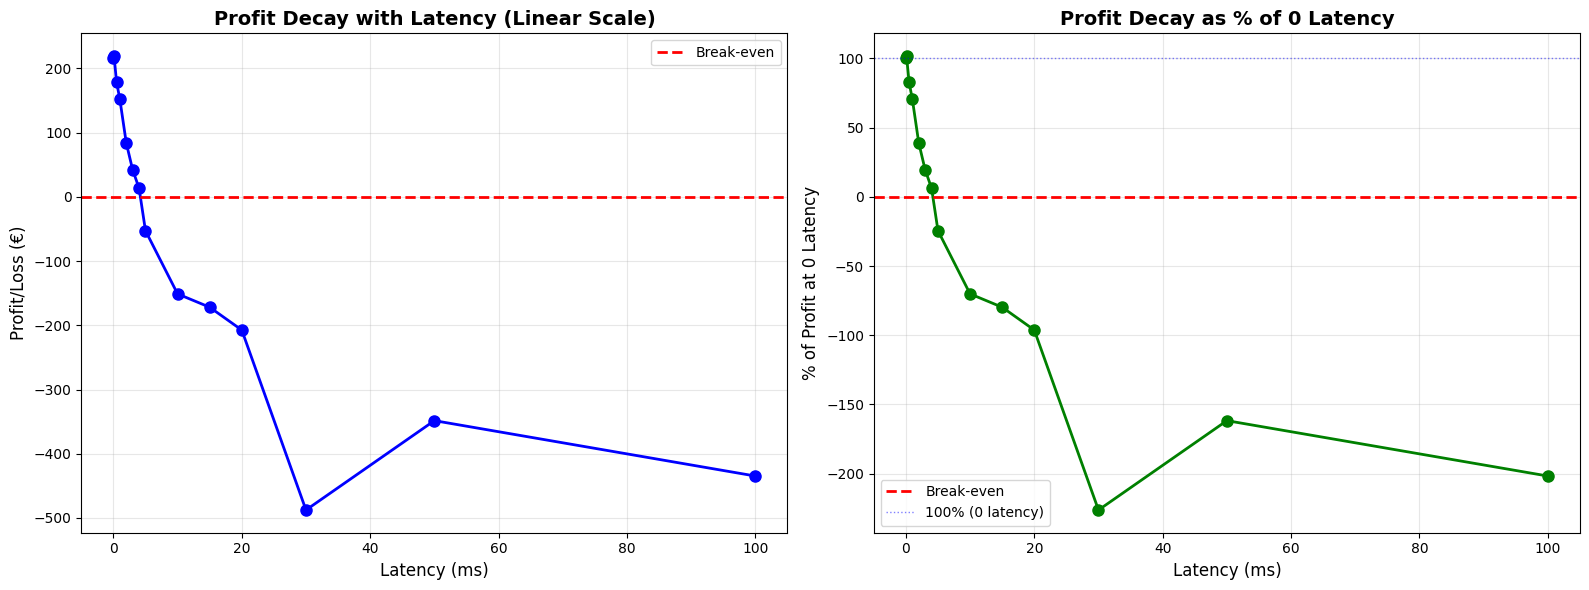


Decay Analysis:
  Maximum profit (0 latency): €215.49
  Profit/Loss at 1.0ms: €152.45
  Profit/Loss at 10.0ms: €-151.15
  Profit/Loss at 100.0ms: €-434.72

Paso 7B.2/7B.2: Análisis de decay completado

                            (OK) FASE 7B COMPLETADA                             



In [9]:
# ============================================================================
# FASE 7B: VISUALIZACIÓN DE DETERIORO TEMPORAL
# ============================================================================

print("="*80)
print("FASE 7B: VISUALIZACIÓN DE DETERIORO TEMPORAL".center(80))
print("="*80)
print()

print("Paso 7B.1/7B.2: Generando gráficos de decay...")
print("   |-- Calculando totales por latencia")
print("   |-- Creando visualizaciones")
print()

# Crear el gráfico de decay usando la función del módulo
create_decay_chart(money_table_data, save_path=str(config.FIGURES_DIR / 'decay_chart.png'))

print()
print("Paso 7B.2/7B.2: Análisis de decay completado")
print()

print("="*80)
print("(OK) FASE 7B COMPLETADA".center(80))
print("="*80)
print()


# FASE 7C: RANKING Y ANÁLISIS DETALLADO DE INSTRUMENTOS {#fase-7c}

## Objetivo

Identificar los instrumentos más rentables y realizar un análisis profundo (deep-dive) de cada uno, incluyendo verificación de razonabilidad.

## ¿Qué hace esta fase?

Esta fase identifica y analiza los top N instrumentos:

1. **Ranking**: Ordena ISINs por profit total a latencia 0
2. **Deep-Dive por Instrumento**: Para cada top ISIN, recarga datos y analiza:
   - Profit total teórico
   - Número de oportunidades
   - Profit promedio y máximo por oportunidad
   - Mejor oportunidad individual
   - Características del instrumento
3. **Sanity Checks**: Verifica que los profits sean razonables

## Criterios de Ranking

Los instrumentos se rankean por:

- **Profit Total a Latencia 0**: Rentabilidad teórica máxima
- **Número de Oportunidades**: Frecuencia de arbitraje
- **Profit por Oportunidad**: Rentabilidad promedio

## Deep-Dive por Instrumento

Para cada instrumento en el ranking, se analiza:

### Métricas Agregadas
- Total Theoretical Profit
- Number of opportunities
- Average profit per opportunity
- Max profit per opportunity
- Total tradeable quantity

### Mejor Oportunidad Individual
- Buy exchange y precio
- Sell exchange y precio
- Profit per share
- Quantity ejecutable
- Total profit de la oportunidad

### Características del Instrumento
- Precio promedio
- Profit promedio por share
- Profit como % del precio (sanity check)

## Sanity Checks

Verificaciones de razonabilidad:

- **Profit % < 1%**: Los profits de arbitraje típicamente son < 1% del precio
- **Precios razonables**: Verificar que los precios estén en rangos normales
- **Cantidades ejecutables**: Verificar que las cantidades sean realistas

## Conceptos Clave

- **Ranking**: Ordenamiento por criterio de rentabilidad
- **Deep-Dive**: Análisis detallado y exhaustivo
- **Sanity Check**: Verificación de razonabilidad de resultados


In [10]:
# ============================================================================
# FASE 7C: RANKING Y ANÁLISIS DETALLADO DE INSTRUMENTOS
# ============================================================================

print("="*80)
print("FASE 7C: RANKING Y ANÁLISIS DETALLADO DE INSTRUMENTOS".center(80))
print("="*80)
print()

print("Paso 7C.1/7C.2: Identificando top instrumentos...")
print("   |-- Rankeando por profit total a latencia 0")
print("   |-- Seleccionando top 5")
print()

# Identificar las top 5 oportunidades usando la función del módulo
top_opportunities_df = identify_top_opportunities(money_table_data, DATA_PATH, DATE, n=5)

print()
print("Paso 7C.2/7C.2: Análisis detallado completado")
print()

# Mostrar tabla resumen si hay datos
if not top_opportunities_df.empty:
    print("TABLA RESUMEN DE TOP OPPORTUNITIES")
    print("-" * 80)
    summary_cols = ['rank', 'isin', 'total_profit', 'num_opportunities', 'avg_profit', 'max_profit']
    available_cols = [col for col in summary_cols if col in top_opportunities_df.columns]
    if available_cols:
        print(top_opportunities_df[available_cols].to_string(index=False))
    print("-" * 80)
    print()
else:
    print("(WARNING) No hay datos disponibles para ranking")
    print()

print("="*80)
print("(OK) FASE 7C COMPLETADA".center(80))
print("="*80)
print()


             FASE 7C: RANKING Y ANÁLISIS DETALLADO DE INSTRUMENTOS              

Paso 7C.1/7C.2: Identificando top instrumentos...
   |-- Rankeando por profit total a latencia 0
   |-- Seleccionando top 5

TOP 5 MOST PROFITABLE ISINs (at 0 latency)

1. ISIN: ES0113900J37
   Total Theoretical Profit: €215.49
   Number of opportunities: 348
   Average profit per opportunity: €0.82
   Max profit per opportunity: €13.29
   Total tradeable quantity: 217,625 shares

   Best Opportunity:
     Buy at: BME @ €8.8150
     Sell at: AQUIS @ €8.8290
     Profit per share: €0.0140
     Quantity: 949 shares
     Total profit: €13.29

TOP 5 SUMMARY TABLE
        ISIN Total Profit at 0 Latency (€)
ES0113900J37                       €215.49

SANITY CHECKS
✓ Checking if profits are reasonable...

ES0113900J37:
  Average price: €8.8884
  Average profit per share: €0.0013
  Average profit %: 0.0144%
  ✓ Profit percentage looks reasonable (<1%)


Paso 7C.2/7C.2: Análisis detallado completado

TABLA RESUMEN

# FASE 7D: SÍNTESIS DE RESULTADOS Y CONCLUSIONES PRINCIPALES {#fase-7d}

## Objetivo

Sintetizar todos los resultados del análisis y responder directamente a las 3 preguntas críticas del estudio, generando conclusiones ejecutivas.

## ¿Qué hace esta fase?

Esta fase genera un resumen ejecutivo que responde:

1. **¿Existen aún oportunidades de arbitraje en acciones españolas?**
2. **¿Cuál es el profit teórico máximo (asumiendo latencia 0)?**
3. **¿Qué tan rápido desaparece este profit cuando el sistema se vuelve más lento?**

## Interpretación de Resultados

### Existencia de Oportunidades

- **SÍ**: Si se encontraron oportunidades con profit > 0
- **NO**: Si no se encontraron oportunidades o profit = 0
- **Cantidad**: Número de ISINs con oportunidades detectadas

### Profit Teórico Máximo

- **Valor absoluto**: Profit total en EUR a latencia 0
- **Top ISIN**: Instrumento más rentable
- **Distribución**: Cómo se distribuye el profit entre instrumentos

### Velocidad de Erosión

- **Curva de Decay**: Cómo decae el profit con la latencia
- **Vida Media**: Tiempo en que el profit se reduce al 50%
- **Puntos Críticos**: Latencia donde el profit se vuelve negativo

## Implicaciones Prácticas

### Para Estrategias de Implementación

- **Latencia Requerida**: Nivel de latencia necesario para mantener rentabilidad
- **Infraestructura**: Tipo de infraestructura necesaria (co-location, fibra, etc.)
- **Costos Operacionales**: Evaluación de costos vs beneficios

### Evaluación de Costos Operacionales

- **Break-even Analysis**: Punto donde profit = costos
- **ROI Estimado**: Retorno sobre inversión considerando infraestructura
- **Riesgo**: Evaluación de pérdidas potenciales con latencia alta

## Conceptos Clave

- **Síntesis**: Resumen ejecutivo de resultados complejos
- **Conclusiones Ejecutivas**: Respuestas directas a preguntas clave
- **Implicaciones Prácticas**: Aplicación de resultados a decisiones reales


In [11]:
# ============================================================================
# FASE 7D: SÍNTESIS DE RESULTADOS Y CONCLUSIONES PRINCIPALES
# ============================================================================

print("="*80)
print("FASE 7D: SÍNTESIS DE RESULTADOS Y CONCLUSIONES PRINCIPALES".center(80))
print("="*80)
print()

print("Paso 7D.1/7D.2: Generando síntesis de resultados...")
print("   |-- Calculando métricas clave")
print("   |-- Respondiendo preguntas críticas")
print()

# Generar respuestas usando la función del módulo
summary_metrics = generate_summary_answers(money_table_data)

print()
print("Paso 7D.2/7D.2: Síntesis completada")
print()

# Mostrar métricas en tabla si están disponibles
if summary_metrics:
    print("MÉTRICAS CLAVE DEL ANÁLISIS")
    print("-" * 80)
    metrics_df = pd.DataFrame([summary_metrics])
    print(metrics_df.to_string(index=False))
    print("-" * 80)
    print()
    
    print("="*80)
    print("(OK) FASE 7D COMPLETADA - ANÁLISIS COMPLETO".center(80))
    print("="*80)
    print()
else:
    print("(WARNING) No hay métricas disponibles para síntesis")
    print()


           FASE 7D: SÍNTESIS DE RESULTADOS Y CONCLUSIONES PRINCIPALES           

Paso 7D.1/7D.2: Generando síntesis de resultados...
   |-- Calculando métricas clave
   |-- Respondiendo preguntas críticas

RESPUESTAS A LAS PREGUNTAS CLAVE

1. ¿Existen aún oportunidades de arbitraje en acciones españolas?
   (OK) ¡SÍ! Se encontraron oportunidades de arbitraje con profit teórico total de €215.49
   (OK) Número de ISINs con oportunidades: 1

2. ¿Cuál es el profit teórico máximo (asumiendo latencia 0)?
   Profit teórico máximo: €215.49
   Top ISIN: ES0113900J37 con €215.49

3. La Curva de 'Decay de Latencia': ¿Qué tan rápido desaparece el profit?
   A 0µs (0ms):     €215.49 (100.0%)
   A 1,000µs (1ms):  €152.45 (70.7%)
   A 10,000µs (10ms): €-151.15 (-70.1%)
   A 100,000µs (100ms): €-434.72 (-201.7%)

   Vida media (50% del profit restante): ~2.0ms

   (WARNING) Algunas latencias resultaron en pérdidas (profits negativos).
     Esto indica que las oportunidades de arbitraje pueden convert

# CONCLUSIONES Y RESULTADOS FINALES

## Resultados Principales

El análisis completo ha generado los siguientes deliverables:

1. **Matrices de Rentabilidad**: Tabla pivot con profit por ISIN y latencia
2. **Visualización de Deterioro**: Gráficos de decay del profit con latencia
3. **Ranking de Instrumentos**: Top 5 ISINs más rentables con análisis detallado
4. **Síntesis de Resultados**: Respuestas a las 3 preguntas críticas

## Hallazgos Clave

Los resultados del análisis responden directamente a las preguntas iniciales:

### 1. Existencia de Oportunidades

**Resultado**: [Se muestra en el output de FASE 7D]

- Número de ISINs con oportunidades detectadas
- Profit teórico total disponible

### 2. Rentabilidad Teórica Máxima

**Resultado**: [Se muestra en el output de FASE 7D]

- Profit total a latencia 0
- Top ISIN identificado
- Distribución de rentabilidad

### 3. Velocidad de Erosión de Valor

**Resultado**: [Se muestra en el output de FASE 7D]

- Vida media del profit
- Puntos críticos de latencia
- Análisis de decay

## Implicaciones

### Análisis Detallado de Mejores Instrumentos

Los instrumentos identificados en el ranking (FASE 7C) representan las mejores oportunidades:

- Características individuales de cada instrumento
- Patrones de arbitraje específicos
- Rentabilidad por oportunidad

### Consideraciones para Estrategias de Implementación

Basado en los resultados de la simulación de latencia (FASE 6):

- **Latencia Requerida**: Nivel de latencia necesario para mantener rentabilidad positiva
- **Infraestructura Necesaria**: Tipo de infraestructura (co-location, fibra óptica, etc.)
- **Ventana de Oportunidad**: Tiempo disponible para ejecutar antes de que desaparezca

### Evaluación de Costos Operacionales

Consideraciones económicas:

- **Break-even Analysis**: Punto donde profit = costos de infraestructura
- **ROI Estimado**: Retorno sobre inversión considerando todos los costos
- **Riesgo de Pérdidas**: Evaluación de pérdidas potenciales con latencia alta

## Archivos Generados

- **Money Table**: Tabla pivot con resultados por ISIN y latencia
- **Decay Chart**: Gráfico guardado en `output/figures/decay_chart.png`
- **Top Opportunities**: Ranking detallado de instrumentos
- **Summary Metrics**: Métricas clave del análisis

## Notas Finales

Este análisis proporciona una evaluación completa de las oportunidades de arbitraje en acciones españolas, considerando el impacto crítico de la latencia en la rentabilidad. Los resultados pueden utilizarse para:

- Evaluar viabilidad de estrategias de arbitraje
- Dimensionar infraestructura necesaria
- Estimar retornos esperados
- Evaluar riesgos operacionales
